# Library

In [3]:
import sys
from torch import nn, cat,rand
import torch

import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import os

from torch import cuda

import pandas as pd
import shutil

# Splitting Datasets into two part which is train and val

In [4]:
raw_data_images_dir = "data/raw_data/raw_images"
raw_data_mask_dir = "data/raw_data/raw_masks"

dest_train_images_dir = "data/train/train_images"
dest_train_masks_dir = "data/train/train_masks"
dest_val_images_dir = "data/val/val_images"
dest_val_masks_dir = "data/val/val_masks"

In [3]:
# Create Dataframe
data={"images": os.listdir(raw_data_images_dir),
"masks" : os.listdir(raw_data_mask_dir)
}
images_data_dir_df = pd.DataFrame(data)

# Split Datasets
train_size = 0.8
train_dataset=images_data_dir_df.sample(frac=train_size,random_state=200)
test_dataset=images_data_dir_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

In [50]:
#Copy to desired folder
def copy_data(src_images_dir,src_images_name,dest_images_dir):
    shutil.copy(os.path.join(src_images_dir,src_images_name),dest_images_dir)

#Copy Train Images
for images in train_dataset['images']:
    copy_data(raw_data_images_dir,images,dest_train_images_dir)

#Copy Train Masks
for images in train_dataset['masks']:
    copy_data(raw_data_mask_dir,images,dest_train_masks_dir)

#Copy val Images
for images in test_dataset['images']:
    copy_data(raw_data_images_dir,images,dest_val_images_dir)

#Copy val Masks
for images in test_dataset['masks']:
    copy_data(raw_data_mask_dir,images,dest_val_masks_dir)

# Hyperparameter

In [5]:
LEARNING_RATE = 1e-4
DEVICE = 'cuda:0' if cuda.is_available() else 'cpu'
BATCH_SIZE = 64
NUM_EPOCHS = 3
NUM_WORKERS = 0
IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = dest_train_images_dir
TRAIN_MASK_DIR = dest_train_masks_dir
VAL_IMG_DIR = dest_val_images_dir
VAL_MASK_DIR = dest_val_masks_dir

In [6]:
class CarvanaDataset(Dataset):
    def __init__(self, image_dir,mask_dir,transform=None):
        self.image_dir = image_dir
        self.mask_dir  = mask_dir
        self.transfrom = transform
        self.images = os.listdir(image_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,index):
        img_path = os.path.join(self.image_dir,self.images[index])
        mask_path = os.path.join(self.mask_dir,self.images[index].replace(".jpg","_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"),dtype=np.float32)
        mask[mask==255.0] = 1.0

        if self.transfrom is not None:
            augmentations = self.transfrom(image=image,mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        
        return image,mask

In [8]:
os.listdir(VAL_IMG_DIR)

['32ff007d9505_06.jpg',
 '31186febd775_11.jpg',
 '6d21aad248e4_14.jpg',
 '9cc257b449d0_08.jpg',
 '8d1a6723c458_04.jpg',
 '8b4b87ad7be6_03.jpg',
 '2cb91c2543fa_04.jpg',
 'bad53871c7d9_06.jpg',
 'b58cc561e560_16.jpg',
 '5588758ee21c_02.jpg',
 'b1a27da4f01c_16.jpg',
 '90fdd8932877_01.jpg',
 '08a646be6b30_01.jpg',
 '6ba36af67cb0_15.jpg',
 '0d1a9caf4350_16.jpg',
 'fc5f1a3a66cf_09.jpg',
 'c4ac16c0dd59_16.jpg',
 '36a3f7f77e85_13.jpg',
 '2ea62c1beee7_14.jpg',
 'a7c1ef8d9cc9_16.jpg',
 '3a7a8f03e713_01.jpg',
 'fd9da5d0bb6f_06.jpg',
 '8d5423cb763c_06.jpg',
 '3810c5e1cdeb_16.jpg',
 '2ea62c1beee7_09.jpg',
 'f591b4f2e006_06.jpg',
 '33a310ea7462_03.jpg',
 'c4f1840b2a65_01.jpg',
 'ad5a6a058944_06.jpg',
 '784ca55262c2_05.jpg',
 '8d78483ce302_09.jpg',
 '6c3470c34408_06.jpg',
 '1ba84b81628e_08.jpg',
 'a1038b207299_13.jpg',
 'a46baa0b3ac0_14.jpg',
 '9274d0b3caa8_12.jpg',
 '2f39abb12388_12.jpg',
 '1952e5f91de0_01.jpg',
 '683ddec95b82_10.jpg',
 'd326cb5c3d12_11.jpg',
 '33a310ea7462_06.jpg',
 '3f202616a2b9_0

# Transformation

In [7]:

train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

# DataLoader

In [8]:
from torch.utils.data import DataLoader

train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': NUM_WORKERS,
                'pin_memory' : PIN_MEMORY
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': NUM_WORKERS,
                'pin_memory' : PIN_MEMORY
                }

training_set = CarvanaDataset(TRAIN_IMG_DIR,TRAIN_MASK_DIR,transform=train_transform)
testing_set = CarvanaDataset(VAL_IMG_DIR,VAL_MASK_DIR,transform=val_transforms)

training_loader = DataLoader(dataset = training_set, **train_params)
testing_loader = DataLoader(dataset = testing_set, **test_params)

In [8]:
data=next(iter(testing_loader))
print("Images: ",data[0].shape)
print("Masks: ",data[1].shape)

Images:  torch.Size([16, 3, 160, 240])
Masks:  torch.Size([16, 160, 240])


# Model Original

In [9]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)
model = UNET(in_channels=3, out_channels=1)
model.to(DEVICE)

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

# My Model

In [9]:
import sys
from torch import nn, cat


#VGG Block, baca: https://d2l.ai/chapter_convolutional-modern/vgg.html
class conv_block(nn.Module):
	def __init__(self, in_channels, mid_channels, out_channels):
		super().__init__()
		self.relu = nn.ReLU(inplace=True) # https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
		
		#LAYER KONVOLUSI 1
		#kernel filter konvolusi 3x3
		#stride pergeseran kernel tiap 1 pixel
		#tambah padding 1 untuk H dan W, padding = 0
		#sehingga output H x W tidak berubah setelah proses convolusi
		#mid channel sbg jml output channel conv pertama
		self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3,
					stride=1, padding=1, padding_mode='zeros')
		self.bn1 = nn.BatchNorm2d(mid_channels) #normalisasi dari sekian channel
		
		#LAYER KONVOLUSI 2
		#kernel filter konvolusi 3x3
		#stride pergeseran kernel tiap 1 pixel
		#tambah padding 1 untuk H dan W, padding = 0
		#sehingga output H x W tidak berubah setelah proses convolusi
		#mid channel sbg jml input channel conv kedua
		self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3,
					stride=1, padding=1, padding_mode='zeros')
		self.bn2 = nn.BatchNorm2d(out_channels) #normalisasi dari sekian channel

		#LAYER KONVOLUSI 3
		#kernel filter konvolusi 3x3
		#stride pergeseran kernel tiap 1 pixel
		#tambah padding 1 untuk H dan W, padding = 0
		#sehingga output H x W tidak berubah setelah proses convolusi
		#mid channel sbg jml input channel conv kedua
		#self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=3,
		#			stride=1, padding=1, padding_mode='zeros')
		#self.bn3 = nn.BatchNorm2d(out_channels) #normalisasi dari sekian channel

	#1 block berisi conv, batch normalisasi, dan aktivasi relu sebanyak 3x
	def forward(self, x): #x adalah tensor yang dimasukkan
		x = self.conv1(x) #konvolusi
		x = self.bn1(x) #normalisasi
		x = self.relu(x) #aktivasi
		x = self.conv2(x) #konvolusi
		x = self.bn2(x) #normalisasi
		x = self.relu(x) #aktivasi
		#x = self.conv3(x) #konvolusi
		#x = self.bn3(x) #normalisasi
		#x = self.relu(x) #aktivasi
		return x



#baca: https://arxiv.org/pdf/1505.04597.pdf
class UNet(nn.Module): 
	#default input channel adalah 3, asumsi pembacaan cv2 adalah RGB
	def __init__(self, n_class, **kwargs):
		super().__init__()
		#jumlah channel feature map yang dikehendaki
		#alias jumlah kernel konvolusi pada setiap layernya
		n_fmap_ch = [32, 64, 128, 256, 512] 
		
			
		#fungsi downsampling (dengan maxpooling) dan upsampling
		#kernel pooling HxW = 2x2, no padding dan
		#stride=2 sehingga dimensi HxW ter-downsampling menjadi H/2 x W/2
		#max pooling, berarti dari 2x2 kotak pixel diambil yang paling besar (max)
		self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) 
		#spatial (HxW) size dikali oleh scale_factor=2
		#sehingga HxW ter-upsampling menjadi H*2 x W*2
		self.up = nn.Upsample(scale_factor=2)
		
		#bagian downsampling
		# format seperti Block di atas: in_channels, mid_channels, out_channels
		# isi block tergantung conv block yang dipakai, lihat di atas
		self.conv0_0 = conv_block(3, n_fmap_ch[0], n_fmap_ch[0])
		self.conv1_0 = conv_block(n_fmap_ch[0], n_fmap_ch[1], n_fmap_ch[1])
		self.conv2_0 = conv_block(n_fmap_ch[1], n_fmap_ch[2], n_fmap_ch[2])
		self.conv3_0 = conv_block(n_fmap_ch[2], n_fmap_ch[3], n_fmap_ch[3])
		#bagian neck
		self.conv4_0 = conv_block(n_fmap_ch[3], n_fmap_ch[4], n_fmap_ch[4])
		
		#bagian upsampling
		#jumlahkan channel output layer sebelumnya dengan channel output pada downsampling yang sesuai
		# isi block tergantung conv block yang dipakai, lihat di atas
		self.conv3_1 = conv_block(n_fmap_ch[3]+n_fmap_ch[4], n_fmap_ch[3], n_fmap_ch[3])
		self.conv2_1 = conv_block(n_fmap_ch[2]+n_fmap_ch[3], n_fmap_ch[2], n_fmap_ch[2])
		self.conv1_1 = conv_block(n_fmap_ch[1]+n_fmap_ch[2], n_fmap_ch[1], n_fmap_ch[1])
		self.conv0_1 = conv_block(n_fmap_ch[0]+n_fmap_ch[1], n_fmap_ch[0], n_fmap_ch[0])
		
		#n_class sebagai channel output akhir
		#1 x konvolusi yang menghasilkan sejumlah n_class output feature map
		#ukuran kernel konvolusi 1x1, sehingga ukuran HxW tidak berubah
		self.final = nn.Conv2d(n_fmap_ch[0], n_class, kernel_size=1)

	def forward(self, input):
		#perhatikan n_fmap_ch = [32, 64, 128, 256, 512] di atas
		#bagian downsampling
		x0_0 = self.conv0_0(input) #in_ch=RGB=3, out_ch=32, HxW=inputHxW=64x128 
		down_x0_0 = self.pool(x0_0) #HxW=(64x128)/2=32x64
		x1_0 = self.conv1_0(down_x0_0)#in_ch=32, out_ch=64
		down_x1_0 = self.pool(x1_0) #HxW=(32x64)/2=16x32
		x2_0 = self.conv2_0(down_x1_0)#in_ch=64, out_ch=128
		down_x2_0 = self.pool(x2_0) #HxW=(16x32)/2=8x16
		x3_0 = self.conv3_0(down_x2_0) #in_ch=128, out_ch=256
		down_x3_0 = self.pool(x3_0) #HxW=(8x16)/2=4x8
		
		#bagian neck
		x4_0 = self.conv4_0(down_x3_0) #in_ch=256, out_ch=512
		
		#bagian upsampling
		#dan concatenate dengan setiap output di downsampling sebelumnya
		#concat pada axis dim 1, karena yang diconcate adalah channel feature mapnya
		#ingat! tensor dimension: batch x channel x H x W ->> 0,1,2,3, axis dim 1 adalah channel
		up_x4_0 = self.up(x4_0) #HxW=(4x8)*2=8x16
		x3_1 = self.conv3_1(cat([x3_0, up_x4_0], dim=1)) #in_ch=256+512=768, out_ch=256, 
		up_x3_1 = self.up(x3_1) #HxW=(8x16)*2=16x32
		x2_1 = self.conv2_1(cat([x2_0, up_x3_1], dim=1)) #in_ch=128+256=384, out_ch=128, 
		up_x2_1 = self.up(x2_1) #HxW=(16x32)*2=32x64
		x1_1 = self.conv1_1(cat([x1_0, up_x2_1], dim=1)) #in_ch=64+128=192, out_ch=64,
		up_x1_1 = self.up(x1_1) #HxW=(32x64)*2=64x128
		x0_1 = self.conv0_1(cat([x0_0, up_x1_1], dim=1)) #in_ch=32+64=96, out_ch=32,
		
		#perhatikan self_final,
		#jika hanya 1 class maka output UNet ini juga 1 lapis layer saja
		#ukuran kernel konvolusi 1x1, sehingga ukuran HxW tidak berubah
		#in_ch=32, out_ch=jumlah_class=1, HxW=128x256
		output = self.final(x0_1)
		#output = nn.Sigmoid(output)
		return output

model = UNet(n_class=1)
model.to(DEVICE)

UNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode=nearest)
  (conv0_0): conv_block(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): conv_block(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): conv_block(
    (relu): ReLU(inplace=True)
    (

## Pred Test

In [26]:
x = torch.randn((3, 3, IMAGE_HEIGHT, IMAGE_WIDTH))
model = UNet(n_class=3)
preds = model(x)
print(x.shape)
print(preds.shape)
# assert preds.shape == x.shape

torch.Size([3, 3, 160, 240])
torch.Size([3, 3, 160, 240])


In [10]:
from tqdm import tqdm
with tqdm(testing_loader, unit="batch") as tepoch:
    for batch_idx, (data,targets) in enumerate(tepoch):
        print(data.shape)
        print(targets.shape)

        print(targets.float().unsqueeze(1).shape)
        break

  0%|          | 0/16 [00:03<?, ?batch/s]

torch.Size([64, 3, 160, 240])
torch.Size([64, 160, 240])
torch.Size([64, 1, 160, 240])


# Train Function

In [8]:
from tqdm import tqdm
def train_fn(loader,model, optimizer, loss_fn, scaler):
    with tqdm(loader, unit="batch") as tepoch:
        for batch_idx, (data,targets) in enumerate(tepoch):
            data = data.to(DEVICE,non_blocking=True)
            targets = targets.float().unsqueeze(1).to(DEVICE,non_blocking=True)

            # forward
            with torch.cuda.amp.autocast():
                predictions = model(data)
                loss = loss_fn(predictions,targets)
            
            #backward
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # update tqdm loop
            tepoch.set_postfix(loss=loss.item())

# Optimizer

In [9]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params =  model.parameters(),lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

# if LOAD_MODEL:
#     load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

# Check Accuracy

In [69]:
def check_accuracy(loader,model,device):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device,non_blocking=True)
            y = y.to(device,non_blocking=True).unsqueeze(1)

            preds = model((x))
            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()
            num_correct +=(preds==y).sum()

            num_pixels += torch.numel(preds)

            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )
        print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
        )
    
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()
    

# Save Model Checkpoint

In [17]:
import torchvision
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
   
    model.eval()
    for idx, (x, y) in enumerate(loader):
        print(x.shape)
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")
        break
    model.train()

# Train

In [12]:
for epoch in range(NUM_EPOCHS):
    train_fn(training_loader,model,optimizer,loss_fn,scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(testing_loader, model, device=DEVICE)

    # print some examples to a folder
    save_predictions_as_imgs(
        testing_loader, model, folder="saved_images/", device=DEVICE
    )
    

100%|██████████| 64/64 [04:20<00:00,  4.07s/batch, loss=0.345]


=> Saving checkpoint
Got 37740967/39091200 with acc 96.55
Dice score: 0.9242768287658691


100%|██████████| 64/64 [04:18<00:00,  4.04s/batch, loss=0.309]


=> Saving checkpoint
Got 38321098/39091200 with acc 98.03
Dice score: 0.9553514719009399


100%|██████████| 64/64 [04:18<00:00,  4.03s/batch, loss=0.277]


=> Saving checkpoint
Got 38450223/39091200 with acc 98.36
Dice score: 0.9624095559120178


# ================================================================= #

# Inference TEST

### Class DataSets

In [21]:
class InferenceCarvanaDatasets:
    def __init__(self, image_dir,image_name,transform=None):
        self.image_dir = image_dir
        self.image_name = image_name
        self.transfrom = transform
    
    def get_image(self):
        img_path = os.path.join(self.image_dir,self.image_name)
        image = np.array(Image.open(img_path).convert("RGB"))
        if self.transfrom is not None:
            print("Masuk trasnform")
            augmentations = self.transfrom(image=image)
            image = augmentations["image"]
        return image

# Load Model Checkpoint
load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)


=> Loading checkpoint


### Fucntion Apply Mask

In [ ]:
import cv2
import matplotlib.pyplot as plt
def apply_mask(image,mask,color_=[0,255,0]):
    # sample data
    img = image

    # sample mask
    mask = mask[:,:,0]

    # color to fill
    color = np.array(color_, dtype='uint8')

    # equal color where mask, else image
    # this would paint your object silhouette entirely with `color`
    masked_img = np.where(mask[...,None], color, img)

    # use `addWeighted` to blend the two images
    # the object will be tinted toward `color`
    out = cv2.addWeighted(img, 0.8, masked_img, 0.2,0)
    plt.imshow(out)

### Load Images

In [91]:
from PIL import Image
img_path = os.path.join(VAL_IMG_DIR,'6d21aad248e4_14.jpg')
im = Image.open(img_path).convert("RGB")
image_data = np.array(im)

IMG_HEIGHT = image_data.shape[0]
IMG_WIDTH = image_data.shape[1]

### Predictions

In [92]:
#Load Data
image_data_transform = InferenceCarvanaDatasets(VAL_IMG_DIR,'6d21aad248e4_14.jpg',transform=val_transforms).get_image()

#Predictions
model.eval()
data = image_data_transform.unsqueeze(0)
data = data.to(DEVICE,non_blocking=True)
with torch.cuda.amp.autocast():
    predictions = model(data)
    predictions = torch.sigmoid(predictions)
    predictions = (predictions > 0.5).float()
    # Detach from GPU
    predictions = predictions.detach().cpu()
predictions

Masuk trasnform


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

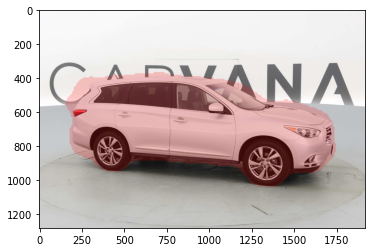

In [93]:
from skimage.transform import resize
mask = resize(predictions[0].permute(1, 2, 0), (IMG_HEIGHT, IMG_WIDTH))
apply_mask(image_data,mask,[255,0,0])